In [1]:
import tensorflow as tf
import copy
import torch.nn.functional as F
from keras.datasets import cifar10
import random
import warnings
import torch.nn as nn
import torchvision
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.manifold import TSNE
from torch import linalg as LA

2025-10-03 06:19:50.583738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759472390.782641      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759472390.838991      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')

In [3]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# ******

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

train_subset, val_subset = torch.utils.data.random_split(
        trainset, [42500, 7500], generator=torch.Generator().manual_seed(1))

trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=128, shuffle=True, num_workers=1)

validloader = torch.utils.data.DataLoader(
    val_subset, batch_size=128, shuffle=True, num_workers=1)

# ******


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

# ******

X_train = np.array(trainset.data)
y_train = np.array(trainset.targets)
X_test = np.array(testset.data)
y_test = np.array(testset.targets)

100%|██████████| 170M/170M [04:46<00:00, 596kB/s] 


In [6]:
print(X_train.shape)

(50000, 32, 32, 3)


In [7]:
print(X_test.shape)

(10000, 32, 32, 3)


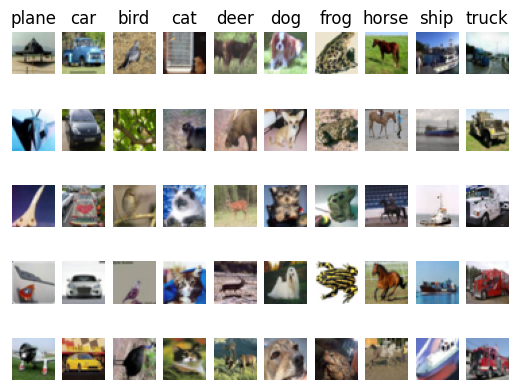

In [8]:
num_classes = len(classes)
samples_per_class = 5
for y, label in enumerate(classes):
    in_class_ids = np.flatnonzero(y_train == y)
    in_class_ids = np.random.choice(in_class_ids, samples_per_class, replace=False)
    for i, idx in enumerate(in_class_ids):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(label)
plt.show()

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_len, out_len, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_len, out_len, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_len)
        self.conv2 = nn.Conv2d(out_len, out_len, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_len)
        
        layers = []
        if stride != 1 or in_len != out_len:
            layers.append(nn.Conv2d(in_len, out_len, kernel_size=1, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_len))
            self.shortcut = nn.Sequential(*layers)

        else:
            self.shortcut = nn.Sequential()
        

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.bn2(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
                
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )
        
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512, stride=1)
        )
        
        self.linear = nn.Linear(512, 10)

    def create_block(self, out_len, stride):
        layers = []
        layers.append(ResidualBlock(self.in_len, out_len, stride=stride))
        self.in_len = out_len
        layers.append(ResidualBlock(self.in_len, out_len, stride=1))
        return nn.Sequential(*layers)
    
    def get_feature_space(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out
    
    def forward(self, x):
        out = self.get_feature_space(x)
        out = self.linear(out)
        return out

In [ ]:
from torchinfo import summary

In [11]:
model = ResNet18()

model = model.to(device)

In [ ]:
summary(model, input_size = (1, 3, 32, 32))

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.000125)
criterion = nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [14]:
for x, y in trainloader:
    print(x.shape)
    print(type(x))
    print(y.shape)
    print(type(y))
    break

torch.Size([128, 3, 32, 32])
<class 'torch.Tensor'>
torch.Size([128])
<class 'torch.Tensor'>


In [ ]:
import torch

num_epochs = 280
print(num_epochs)
train_acc = []
train_losses = []
val_acc_list = []  # Đổi tên cho nhất quán
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    val_loss = 0
    acc = 0
    cnt = 0
    total_samples = 0  # Để tính accuracy đúng

    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        acc += (torch.argmax(output, dim=1) == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(trainloader)
    train_losses.append(train_loss)

    acc /= total_samples
    train_acc.append(acc)

    model.eval()
    val_acc = 0
    total_val_samples = 0

    with torch.no_grad():
        for X, y in validloader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_acc += (torch.argmax(output, dim=1) == y).sum().item()
            total_val_samples += y.size(0)

        val_loss /= len(validloader)
        val_losses.append(val_loss)

        val_acc /= total_val_samples
        val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {acc:.4f}, Val Acc: {val_acc:.4f}")


In [ ]:
import os

# Kaggle sẽ tự nhận file trong thư mục /kaggle/working khi bạn Save Version
save_dir = "/kaggle/working/results"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/results/cifar10-resnet18.pth")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Lưu ảnh
plt.savefig(f"{save_dir}/accuracy.png")
plt.close()   # đóng để tránh hiện lại


loss = 0.4020
accuracy = 91.1900%


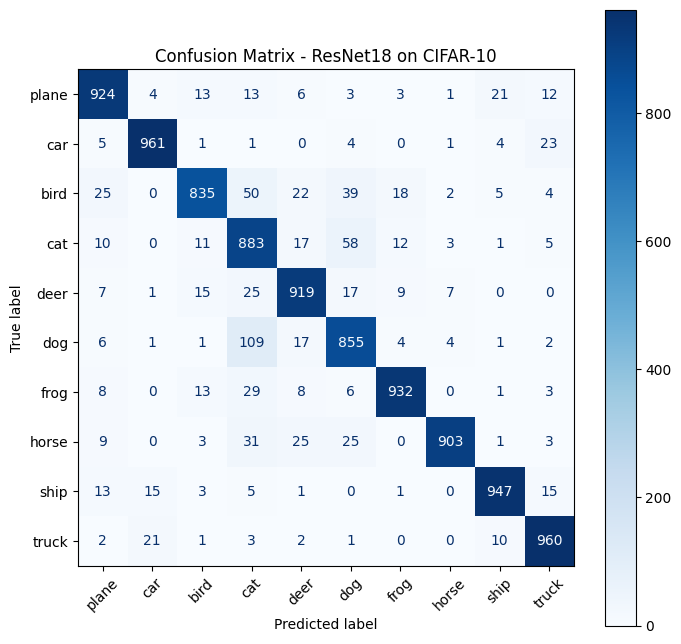

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss = 0.0
correct_number = 0

all_preds = []
all_labels = []

model = ResNet18()
model.load_state_dict(torch.load('/kaggle/input/cifar-10/pytorch/default/1/cifar10-resnet18.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    for _, (data, target) in enumerate(testloader): 
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)    
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        correct_number += correct.sum()

# Tính loss và accuracy
test_loss = test_loss / len(testloader.dataset)
total_accuracy = 100. * correct_number / len(testloader.dataset)
print('loss = {:.4f}'.format(test_loss))
print('accuracy = {:.4f}%'.format(total_accuracy))

# Vẽ confusion matrix
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix - ResNet18 on CIFAR-10")
plt.savefig("confusion_matrix.png", dpi=300)  # lưu ra file để chèn vào LaTeX
plt.show()


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.savefig(f"{save_dir}/loss.png")
plt.close()


loss = 0.4020
accuracy = 91.1900%
